# Electrolyte models

In [8]:
using Pkg, Revise
Pkg.activate("..")
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot
# ternary = pyimport("ternary")

PyPlot

In this notebook, we will be giving examples on how to use activity models within `Clapeyron.jl`. We include examples of how one can customise their activity model and how it can be used in tangent with a cubic equation of state.

In [10]:

mapping = [(("water",1),)=>(("water",1)),
           (("methanol",1),)=>(("methanol",1)),
           (("water",1),("methanol",1))=>(("water.methanol",1))]
fluid = PCSAFT(["water","methanol"]; assoc_options=AssocOptions(combining=:elliott))
fluid.params.epsilon["water","methanol"] *= (1+0.18)
solid = SolidHfus(["water","methanol","water.methanol"])
model = CompositeModel(["water","methanol"];mapping=mapping,fluid=fluid,solid=solid)

Composite Model with 2 components:
 Solid Model: SolidHfus("water", "methanol", "water.methanol")
 Fluid Model: PCSAFT{BasicIdeal, Float64}("water", "methanol")

In [11]:
sle_solubility(model,1e5,160,[1,1];solute=["water.methanol"])

2-element Vector{Float64}:
 0.2620200474632051
 0.7379799525367949

In [ ]:
x_water = zeros(100)
T_water = LinRange(solid.params.Tm["water"]*0.9999,155,100)

for i in 1:100
    x_water[i] = sle_solubility(model,1e5,T_water[i],[1,1];solute=["water"])[1]
end

x_meoh = zeros(100)
T_meoh = LinRange(solid.params.Tm["methanol"]*0.9999,155,100)

for i in 1:100
    x_meoh[i] = sle_solubility(model,1e5,T_meoh[i],[1,1];solute=["methanol"])[1]
end

x_mix = zeros(100)
T_mix = LinRange(solid.params.Tm["water.methanol"]*0.9999,155,100)

for i in 1:100
    x_mix[i] = sle_solubility(model,1e5,T_mix[i],[1,1];solute=["water.methanol"])[1]
end

In [ ]:
plt.clf()
plt.plot(1 .-x_water,T_water,label="water")
plt.plot(1 .-x_meoh,T_meoh,label="methanol")
plt.plot(1 .-x_mix,T_mix,label="water-methanol")
plt.xlim(0,1)
plt.ylim(150,280)
plt.ylabel("Temperature (K)")
plt.xlabel("Mole fraction of methanol")
plt.legend()
display(plt.gcf())

# Bulk properties of aqueous sodium chloride
In the first instance, we will obtain the bulk properties of sodium chloride in water. Namely the change in the saturation pressure and liquid density, as well as mean ionic activity coefficient and osmotic coefficient.

The first step is to create the model. In this case, neutral and charged species are treated separately:
```julia
model = EoS(["solvent"],["cation","anion"])
```
In this case, we'll just consider aqueous sodium chloride in ePC-SAFT:

In [12]:
model = ePCSAFT(["water"],["sodium","chloride"])

ePCSAFT{BasicIdeal, pharmaPCSAFT{BasicIdeal}, DH{ConstRSP}} with 3 components:
 "water"
 "sodium"
 "chloride"

As Clapeyron only supports ion-based approaches, salts must be defined separately:

In [13]:
salts = [("sodium chloride",("sodium"=>1,"chloride"=>1))]

1-element Vector{Tuple{String, Tuple{Pair{String, Int64}, Pair{String, Int64}}}}:
 ("sodium chloride", ("sodium" => 1, "chloride" => 1))

To specify the composition of the charged components, it is often easier to use molalities. However, Clapeyron functions use molar compositions. To convert between the two, simply:

In [14]:
m = 1.0 # mol/kg
x = molality_to_composition(model,salts, m) # mol/mol

3-element Vector{Float64}:
 0.9652224930507842
 0.017388753474607933
 0.017388753474607933

From here, to obtain the saturation properties, as charged species are involatile, we can use `FugBubblePressure` to assign them as such:

In [20]:
method = FugBubblePressure(nonvolatiles=["sodium","chloride"])
bub = bubble_pressure(model, 298.15, x, method)

p = bub[1]
ρl = Clapeyron.molecular_weight(model, x) / bub[2]

954.0130103837033

We can trace this for a range of molalities:

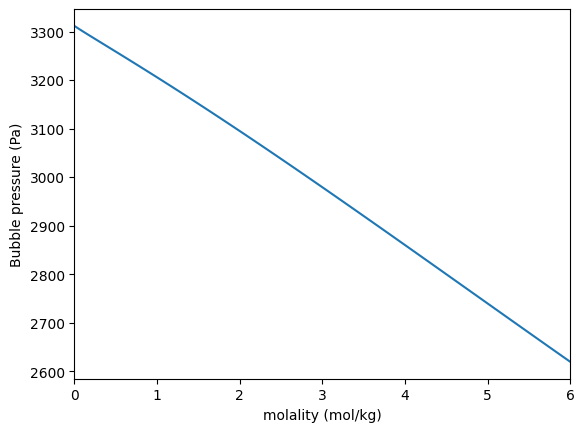

In [22]:
N = 100
m = LinRange(0., 6, N)

p = zeros(N)
ρl = zeros(N)
for i in 1:N
    x = molality_to_composition(model,salts, m[i]) # mol/mol
    bub = bubble_pressure(model, 298.15, x, method)
    p[i] = bub[1]
    ρl[i] = Clapeyron.molecular_weight(model, x) / bub[2]
end

plt.clf()
plt.plot(m,p)
plt.xlim(0,6)
plt.xlabel("molality (mol/kg)")
plt.ylabel("Bubble pressure (Pa)")
display(plt.gcf())

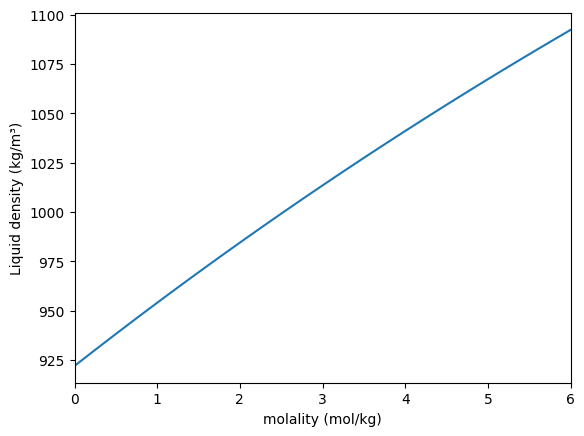

In [23]:
plt.clf()
plt.plot(m,ρl)
plt.xlim(0,6)
plt.xlabel("molality (mol/kg)")
plt.ylabel("Liquid density (kg/m³)")
display(plt.gcf())

Mean ionic activity and osmotic coefficients are a bit more-straightforward to obtain. As these are defined using molality scales, they accept them as a direct input:

In [28]:
p = 1e5
T = 298.15
m = 1.0

γ = mean_ionic_activity_coefficient(model, salts, p, T, m)
ϕ = osmotic_coefficient(model, salts, p, T, m)

1-element Vector{Float64}:
 0.8992402796012607

And once again, we can trace these properties for a range of molalities:

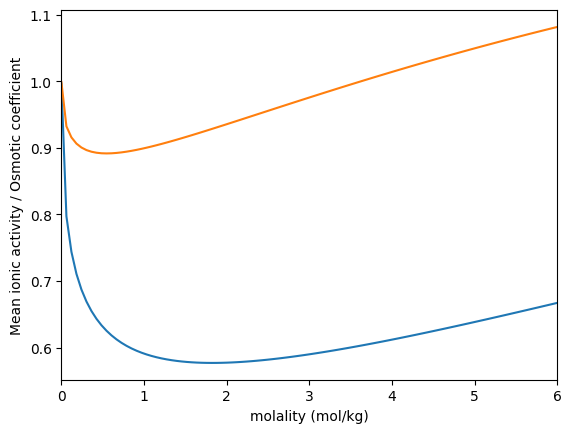

In [33]:
N = 100
m = LinRange(1e-5, 6, N)

γ = zeros(N)
ϕ = zeros(N)

for i in 1:N
    γ[i] = mean_ionic_activity_coefficient(model, salts, p, T, m[i])[1]
    ϕ[i] = osmotic_coefficient(model, salts, p, T, m[i])[1]
end

plt.clf()
plt.plot(m,γ)
plt.plot(m,ϕ)
plt.xlim(0,6)
plt.xlabel("molality (mol/kg)")
plt.ylabel("Mean ionic activity / Osmotic coefficient")
display(plt.gcf())

Mean ionic activity and osmotic coefficients are also sometimes defined also the saturation boundary of the solvent. These calculations can be performed by simply using the `_sat` versions of these functions:

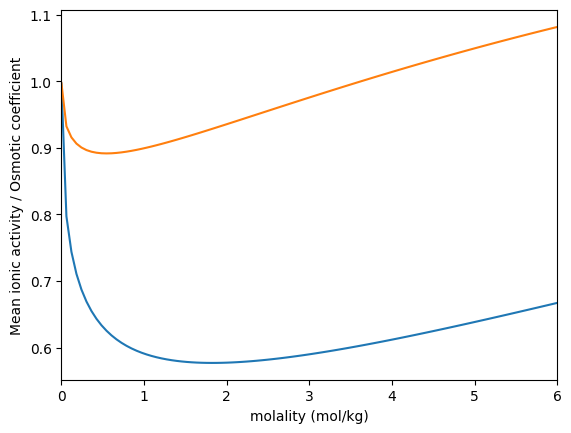

In [34]:
N = 100
m = LinRange(1e-5, 6, N)

γ = zeros(N)
ϕ = zeros(N)

for i in 1:N
    γ[i] = mean_ionic_activity_coefficient_sat(model, salts, T, m[i])[1]
    ϕ[i] = osmotic_coefficient_sat(model, salts, T, m[i])[1]
end

plt.clf()
plt.plot(m,γ)
plt.plot(m,ϕ)
plt.xlim(0,6)
plt.xlabel("molality (mol/kg)")
plt.ylabel("Mean ionic activity / Osmotic coefficient")
display(plt.gcf())

# Mixed salts
One can defined a model with multiple ions. For example:

In [35]:
model = ePCSAFT(["water"],["sodium","potassium","chloride"])

ePCSAFT{BasicIdeal, pharmaPCSAFT{BasicIdeal}, DH{ConstRSP}} with 4 components:
 "water"
 "sodium"
 "potassium"
 "chloride"

Where two salts can now be defined:

In [36]:
salts = [("sodium chloride",("sodium"=>1,"chloride"=>1)),
         ("potassium chloride",("potassium"=>1,"chloride"=>1))]

2-element Vector{Tuple{String, Tuple{Pair{String, Int64}, Pair{String, Int64}}}}:
 ("sodium chloride", ("sodium" => 1, "chloride" => 1))
 ("potassium chloride", ("potassium" => 1, "chloride" => 1))

With two molalities:

In [37]:
m = [1.,0.5]
x = molality_to_composition(model, salts, m) # mol/mol

4-element Vector{Float64}:
 0.9487253419642547
 0.017091552678581798
 0.008545776339290899
 0.025637329017872697

The rest will continue working as-is:

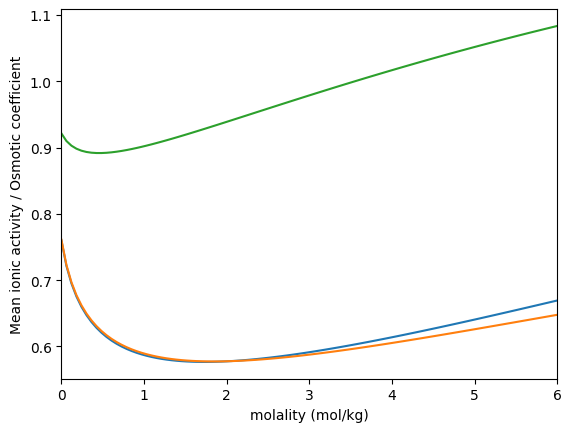

In [39]:
N = 100
m = LinRange(1e-5, 6, N)

γ = zeros(N,2)
ϕ = zeros(N)

for i in 1:N
    γ[i,:] = mean_ionic_activity_coefficient_sat(model, salts, T, [m[i],0.1])
    ϕ[i] = osmotic_coefficient_sat(model, salts, T, [m[i],0.1])[1]
end

plt.clf()
plt.plot(m,γ[:,1])
plt.plot(m,γ[:,2])
plt.plot(m,ϕ)
plt.xlim(0,6)
plt.xlabel("molality (mol/kg)")
plt.ylabel("Mean ionic activity / Osmotic coefficient")
display(plt.gcf())

# Mixed solvents
In a similar way, multiple solvents can be defined:

In [40]:
model = ePCSAFT(["water","ethanol"],["sodium","chloride"])

ePCSAFT{BasicIdeal, pharmaPCSAFT{BasicIdeal}, DH{ConstRSP}} with 4 components:
 "water"
 "ethanol"
 "sodium"
 "chloride"

However, now, our molality arguments take a second input: solvent composition, where the ion-free solvent fractions are defined.

In [41]:
salts = [("sodium chloride",("sodium"=>1,"chloride"=>1))]
z0 = [0.5,0.5]
m = 1.0

z = molality_to_composition(model, salts, m, z0) # mol/mol

4-element Vector{Float64}:
 0.4698875919866046
 0.4698875919866046
 0.030112408013395334
 0.030112408013395334

This is done equivalently in the mean ionic activity and osmotic coefficients:

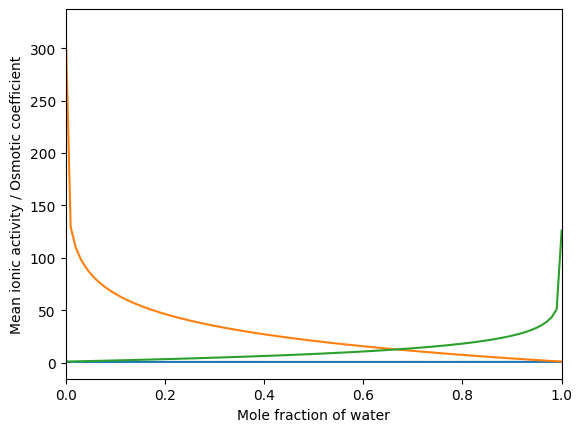

In [52]:
N = 100
x0 = LinRange(1e-5, 1-1e-5, N)
m = 1.
p = 1e5
T = 298.15

γ = zeros(N)
ϕ = zeros(N,2)

for i in 1:N
    γ[i] = mean_ionic_activity_coefficient_sat(model, salts, T, m,[x0[i],1-x0[i]])[1]
    ϕ[i,:] = osmotic_coefficient_sat(model, salts, T, m,[x0[i],1-x0[i]])
end

plt.clf()
plt.plot(x0,γ[:,1])
plt.plot(x0,ϕ[:,1])
plt.plot(x0,ϕ[:,2])
plt.xlim(0,1)
# plt.ylim(0,40)
plt.xlabel("Mole fraction of water")
plt.ylabel("Mean ionic activity / Osmotic coefficient")
display(plt.gcf())

# Solubility of sodium chloride in water
Another vital property of electrolytes is their solubility limit. This too can be obtained in Clapeyron using a combination of the electrolyte model and the `SolidKs` model, within the `CompositeModel` framework. However, unlike conventional solids, salts have to be neutral. As such, special mapping needs to be used:

In [57]:
fluid = SAFTVREMie(["water"],["sodium","chloride"])
solid = SolidKs(["water","sodium.chloride"])
mapping = [(("water",1),)=>(("water",1)),
           (("sodium",1),("chloride",1))=>(("sodium.chloride",1))]

model = CompositeModel(["water","sodium","chloride"];mapping=mapping,fluid=fluid,solid=solid)

Composite Model with 3 components:
 Solid Model: SolidKs("water", "sodium.chloride")
 Fluid Model: ESElectrolyte{BasicIdeal, SAFTVRMie{BasicIdeal, Float64}, MSABorn{Schreckenberg}}("water", "sodium", "chloride")

Once this is down, one can obtain the solubility limit at a given temperature. One of the downsides, however, is that a composition is obtained, which must be converted to molality:

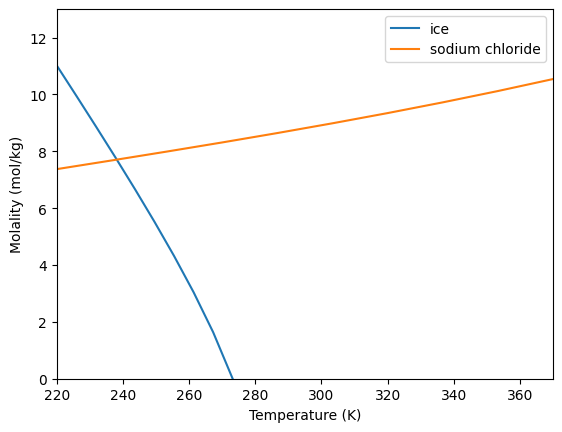

In [58]:
m_ice = zeros(10)
T_ice = LinRange(220,273.15,10)

for i in 1:10
    # println(i)
    s = sle_solubility(model,1e5,T_ice[i],[1,1,1];solute=["water"],x0=[0.1])
    m_ice[i] = s[2]/(s[1]*0.018)
end

T_nacl = LinRange(220,370,10)
m_nacl = zeros(length(T_nacl))
x0 = [-1.2]
for i in 1:length(T_nacl)
    println(i)
    s = sle_solubility(model,1e5,T_nacl[i],[1,1,1];solute=["sodium.chloride"],x0=[-1.2])
    m_nacl[i] = s[2]/(s[1]*0.018)
end

plt.clf()
plt.plot(T_ice,m_ice,label="ice")
plt.plot(T_nacl,m_nacl,label="sodium chloride")
# plt.plot(T_nacl2,m_nacl2,label="sodium chloride dihydrate")
plt.ylabel("Molality (mol/kg)")
plt.xlabel("Temperature (K)")
plt.legend()
plt.xlim(220,370)
plt.ylim(0,13)
display(plt.gcf())


And with that, it is possible to predict under what conditions the salt, or solvent, will crash out of solution.